In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn

print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'sklearn: {sklearn.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
import sys
print(f'Python: {sys.version}')
!which python  

pandas: 2.1.4
numpy: 1.26.2
sklearn: 1.2.2
matplotlib: 3.8.0
Python: 3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]
/Users/walter/anaconda3/bin/python


## Ensemble Methods

[walter.daelemans@uantwerpen.be](mailto:walter.daelemans@uantwerpen.be)

Ensemble learning refers to the methodology of combining several learners (component learners) to create a more robust and accurate overall model (the ensemble). 

The combination of component outputs can be done by voting (for classification) or averaging (for regression).

A diverse set of ML models may make different (types of) errors, and by combining many such models, these errors may cancel out. You can consider it a sort of 'many know more than one' or 'wisdom of the crowd' implementation.

In order to work, each of the the component learners should be reasonably accurate (perform at least better than chance) and the different component learners should make different mistakes. If they all would make the same mistakes, the canceling out of errors would not work. If they would do barely better than chance they may not contribute a lot to or even distract the ensemble.

Ensembles can be created by combining different algorithms (e.g., logistic regression, decision trees, and k-NN) or by training the same algorithm on different subsets of data (**bagging**, e.g., RandomForestClassifier). They can also involve varying hyperparameters or random initializations (e.g., in neural networks).

Another approach is boosting, where a weak learner is iteratively improved by focusing on the errors of previous iterations (**boosting**, e.g., AdaBoostClassifier).


In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [4]:
adult = pd.read_csv("homework/adult_small.csv")

X = adult.drop(columns=['income'])
y = adult['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

ohe = OneHotEncoder()
scaler = StandardScaler()

preprocessor = make_column_transformer(
    (scaler, ['age', 'education.num', 'hours.per.week']),
    (ohe, ['race', 'sex'])
)

logreg = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
svm = SVC(random_state=42, probability=True)

dummy_clf = DummyClassifier(strategy='stratified')

### Evaluate the component classifiers

In [6]:
dummy_pipe = make_pipeline(preprocessor, dummy_clf)
print("Stratified baseline results:")
dummy_scores = cross_val_score(dummy_pipe, X_train, y_train, cv=10, scoring='f1_macro')
print(f"F1 Macro (Mean ± Std): {dummy_scores.mean():.4f} ± {dummy_scores.std():.4f}")

pipe1 = make_pipeline(preprocessor, logreg)
print("Logistic regression results:")
lr_scores = cross_val_score(pipe1, X_train, y_train, cv=10, scoring='f1_macro')
print(f"F1 Macro (Mean ± Std): {lr_scores.mean():.4f} ± {lr_scores.std():.4f}")

pipe2 = make_pipeline(preprocessor, knn)
print("Knn results:")
knn_scores = cross_val_score(pipe2, X_train, y_train, cv=10, scoring='f1_macro')
print(f"F1 Macro (Mean ± Std): {knn_scores.mean():.4f} ± {knn_scores.std():.4f}")

pipe3 = make_pipeline(preprocessor, svm)
print("SVM results:")
svm_scores = cross_val_score(pipe3, X_train, y_train, cv=10, scoring='f1_macro')
print(f"F1 Macro (Mean ± Std): {svm_scores.mean():.4f} ± {svm_scores.std():.4f}")

Stratified baseline results:
F1 Macro (Mean ± Std): 0.4918 ± 0.0336
Logistic regression results:
F1 Macro (Mean ± Std): 0.6736 ± 0.0204
Knn results:
F1 Macro (Mean ± Std): 0.6798 ± 0.0234
SVM results:
F1 Macro (Mean ± Std): 0.6702 ± 0.0226


While the three models seem to do better than chance baseline, they also seem to be pretty close to each other. To check whether they make different mistakes, you could do a correlation analysis of their output.

In [8]:
voting_clf = VotingClassifier(
    estimators=
    [('lr', logreg), ('knn', knn), ('svm', svm)],
    voting='soft')
# 'soft' votes over the probabilities output of the component models, 
# 'hard' votes over the classes output of the models

voting_pipe = make_pipeline(preprocessor, voting_clf)

print("Voting results:")
voting_scores = cross_val_score(voting_pipe, X_train, y_train, cv=10, scoring='f1_macro')
print(f"F1 Macro (Mean ± Std): {voting_scores.mean():.4f} ± {voting_scores.std():.4f}")

Voting results:
F1 Macro (Mean ± Std): 0.6761 ± 0.0217


### Bagging with Random Forest

In [10]:
rf = RandomForestClassifier(n_estimators=500) 
rf_pipe = make_pipeline(preprocessor, rf)
print("Bagging with Random Forest results:")
rf_scores = cross_val_score(rf_pipe, X_train, y_train, cv=10, scoring='f1_macro')
print(f"F1 Macro (Mean ± Std): {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")

Bagging with Random Forest results:
F1 Macro (Mean ± Std): 0.6670 ± 0.0427


### Boosting with Gradient Boosting 

Gradient boosting is an iterative technique that builds a strong model by combining multiple weak learners. Regression trees are fit on the negative gradient of the loss function. At each step, it fits a new model to the residual errors (mistakes) of the previous one, minimizing the overall loss function and improving accuracy.

In [12]:
gb = GradientBoostingClassifier(n_estimators=100)
gb_pipe = make_pipeline(preprocessor, gb)
print("Boosting with Gradient Boosting results:")
gb_scores = cross_val_score(gb_pipe, X_train, y_train, cv=10, scoring='f1_macro')
print(f"F1 Macro (Mean ± Std): {gb_scores.mean():.4f} ± {gb_scores.std():.4f}")

Boosting with Gradient Boosting results:
F1 Macro (Mean ± Std): 0.6921 ± 0.0216


In [13]:
# Best results with gradient boosting, use this on test
gb_pipe.fit(X_train, y_train)
print(classification_report(y_test, gb_pipe.predict(X_test)))

              precision    recall  f1-score   support

       <=50K       0.80      0.94      0.86       713
        >50K       0.69      0.38      0.49       272

    accuracy                           0.78       985
   macro avg       0.75      0.66      0.67       985
weighted avg       0.77      0.78      0.76       985



Conclusion: No luck with this dataset: all component and ensemble classifiers seem to reach comparable results. Probably we have a **ceiling effect** here: the features are not informative enough and all algorithms are already at the ceiling of what is possible to achieve for this task.

Of course, the different component models and the ensemble methods should still be optimized using gridsearch.

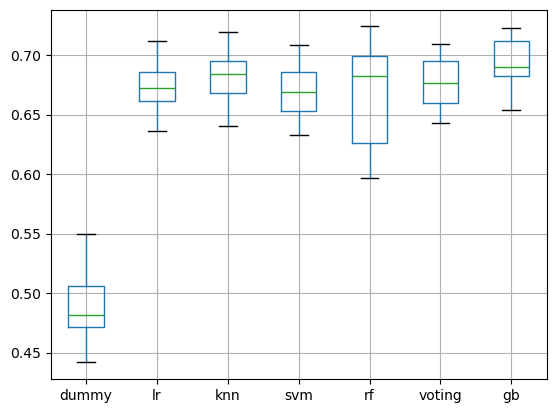

In [15]:
data = {'dummy': dummy_scores, 'lr': lr_scores, 'knn': knn_scores, 
        'svm': svm_scores, 'rf': rf_scores, 'voting': voting_scores, 'gb': gb_scores}
results = pd.DataFrame(data)
results.boxplot();